---
title       : "Multiple Layer Networks" 
subtitle    : ""
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "../ml.bib"
options:
      out_width : 100%
      wrap : true
      fig_width : 800
      fig_height : 800
      dpi : 192
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 


### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/NeuralNetworkEconomics.jl). The same
document generates both static webpages and associated [jupyter
notebook](mlp.ipynb). 

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end
# Make gr backend work with λ and other unicode
ENV["GKS_ENCODING"] = "utf-8"

using NeuralNetworkEconomics
docdir = joinpath(dirname(Base.pathof(NeuralNetworkEconomics)), "..","docs")

using Pkg
Pkg.activate(docdir)
Pkg.instantiate()

Activating environment at `~/.julia/dev/NeuralNetworkEconomics/docs/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Introduction

[The previous notes](slp.md) discussed single layer neural
networks. These notes will look at multiple layer networks.

## Additional Reading

- @goodfellow2016 [*Deep Learning*](http://www.deeplearningbook.org)
- [`Knet.jl`
  documentation](https://denizyuret.github.io/Knet.jl/latest/)
  especially the textbook
- @klok2019 *Statistics with Julia:Fundamentals for Data Science,
  MachineLearning and Artificial Intelligence*
- @farrel2018 "Deep Neural Networks for Estimation and Inference" 
    
  
# Multiple Layer Neural Networks

A multiple layer feed forward neural network (aka a multi-layer
perception) connects many single layer networks. A multi-layer
perceptron can be written recursively. The outermost layer of a
multi-layer perception looks like a generalized linear model:
$$
\hat{f}(x) = \psi_L(x_L' w_L+ b_L)
$$
where $x_L, w_L \in \R^{H_L}$, $b_L \in \R$, and 
$\psi_L: \R \to \R$. For regression problems, $\psi_L$ is typically
the identity function. 

In a generalized linear model, $x_L$ would be data. In a multilayer
network, $x_L \in \R^{H_{L}}$ is the output of a previous
layer. Specificaly, for $k \in \{ 1, ...., H_L\}$, 
$$
x_{k,L} = \psi_{k, L-1}(x_{L-1}'w_{k,L-1} + b_{k,L-1})
$$
where $x_{L-1}, w_{L-1} \in \R^{H_{L-1}}$, $b_{L-1} \in \R$, and 
$\psi_{k,L-1}: \R \to \R$. This continues recursively until 
$x_0 = x \in \R^d$ is the data. 

$L$ is the **depth** of the network.

<div class="alert alert-danger">
When $L$ is sufficiently large, you have a deep neural network,
and can attract grant money by calling  your research deep
learning and/or AI. 
</div>

$H_\ell$ is the **width** of layer $\ell$. 
Following @farrel2018, we will let 
$$
U = \sum_{\ell=1}^L H_\ell
$$
denote the number of units. The number of parameters is 
$$ 
W = \sum_{\ell=1}^L (H_{\ell-1}+1) H_\ell 
$$
where $H_0 = d$ is the dimension of the data. 

In most applications, the activation within a layer is the same for
each unit, i.e. $\psi_{k,\ell}$ does not vary with $k$. In large
networks and/or with large datasets, activation functions are usually
(leaky) rectified linear to allow faster computation. 

The combination of depths ($L$), width ($H_\ell$), and activation functions
($\psi$) are collectively referred to as the network architecture. 


## First Example

As a starting example, here is some code that fits a multi-layer
network to the same simulated data as in [the notes on single layer
networks](slp.md). 

Simulating data and setting up.

In [2]:
using Plots, Flux, Statistics, ColorSchemes
# some function to estimate
f(x) = sin(x^x)/2^((x^x-π/2)/π)
function simulate(n,s=1)
  x = rand(n,1).*π
  y = f.(x) .+ randn(n).*s
  (x,y)
end
x, y = simulate(1000, 0.5)
xt = reshape(x, 1, length(x))
yt = reshape(y, 1, length(y))
xg = 0:0.01:π
cscheme = colorschemes[:BrBG_4];
dimx = 1
xt = reshape(Float32.(x), 1, length(x))
yt = reshape(Float32.(y), 1, length(y))

1×1000 Array{Float32,2}:
 1.2654  0.604831  0.541235  0.919446  …  0.525933  -0.248982  1.55494

We now define our models. The second model is a multi-layer network
with 3 layers each of width 3. The first model is a single-layer
network with width 15. This makes the total number of
parameters in the two networks equal. For both networks we normalise
$x$ and then use Flux's default initial values (these set $b=0$ and
$w$ random).

Model 1 = Chain(#3, Dense(1, 15, leakyrelu), Dense(15, 1))
 46 parameters in 2 layers
Model 1, 1 iterations, loss=0.83605725
Model 1, 500 iterations, loss=0.27857462
Model 1, 1000 iterations, loss=0.27615282
Model 1, 1500 iterations, loss=0.27475324
Model 1, 2000 iterations, loss=0.27378342
Model 1, 2500 iterations, loss=0.27297294
Model 1, 3000 iterations, loss=0.2717115
Model 1, 3500 iterations, loss=0.2708255
Model 1, 4000 iterations, loss=0.2701442
Model 1, 4500 iterations, loss=0.26961055
Model 1, 5000 iterations, loss=0.26918602


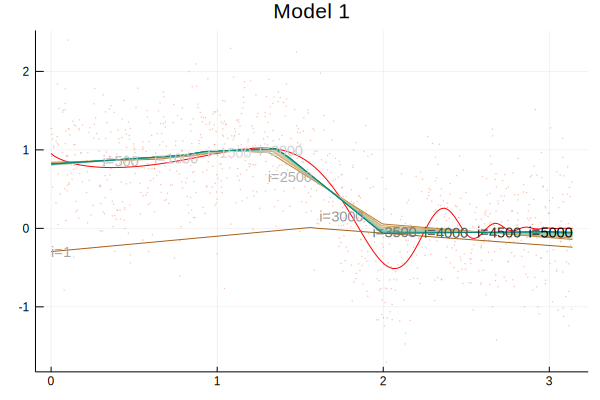

 10.824950 seconds (24.50 M allocations: 2.845 GiB, 9.11% gc time)
Model 2 = Chain(#4, Dense(1, 3, leakyrelu), Dense(3, 3, leakyrelu), Dense(3, 3, leakyrelu), Dense(3, 1))
 34 parameters in 4 layers
Model 2, 1 iterations, loss=0.6886976
Model 2, 500 iterations, loss=0.26678112
Model 2, 1000 iterations, loss=0.26676974
Model 2, 1500 iterations, loss=0.26676896
Model 2, 2000 iterations, loss=0.26675707
Model 2, 2500 iterations, loss=0.26675665
Model 2, 3000 iterations, loss=0.26675218
Model 2, 3500 iterations, loss=0.26674438
Model 2, 4000 iterations, loss=0.26674324
Model 2, 4500 iterations, loss=0.26673982
Model 2, 5000 iterations, loss=0.26673332

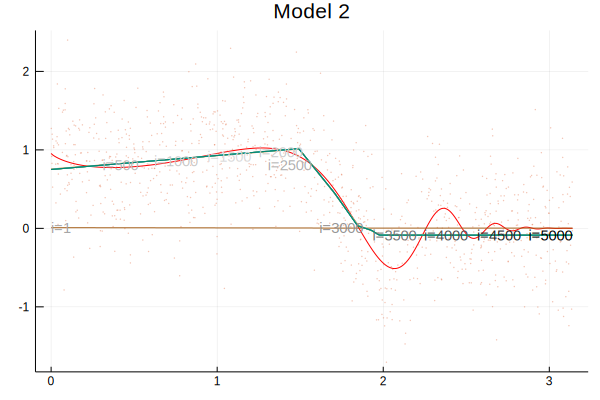


  2.988976 seconds (4.65 M allocations: 1.253 GiB, 7.60% gc time)


In [3]:
models = [ Chain(x->Flux.normalise(x, dims=2),
                 Dense(dimx, 15, Flux.leakyrelu),
                 Dense(15, 1)),
           Chain(x->Flux.normalise(x, dims=2),
                 Dense(dimx, 3, Flux.leakyrelu),
                 Dense(3, 3, Flux.leakyrelu),
                 Dense(3, 3, Flux.leakyrelu),
                 Dense(3, 1))
           ]


figs = Array{typeof(plot(0)),1}(undef,length(models))
initmfigs = Array{typeof(plot(0)),1}(undef,length(models))

for r in eachindex(models)
  m = models[r]
  println("Model $r = $m")
  nparm = sum([length(m[i].W) + length(m[i].b) for i in 2:length(m)])
  println(" $nparm parameters in $(length(m)-1) layers")
  initmfigs[r] = plot(xg, Tracker.data(m[1:(end-1)](xg'))', lab="", legend=false)  
  figs[r]=plot(xg, f.(xg), lab="", title="Model $r", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 5000
  @time for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(x),y), Flux.params(m),
                #[(xt[:,b], yt[:,b]) for b in Base.Iterators.partition(1:length(yt), 500)],
                [(xt, yt)],
                Flux.AMSGrad() ) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(xt),yt)),100))
    if i==1 || (i % (maxiter ÷ 10)==0)
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("Model $r, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
  display(figs[r])
end

In this simulation setup, the performance of the two network
architectures is hard to distinguish. The multi-layer network takes a
bit longer to train. Depending on the randomly simulated data, 
and randomly drawn initial values, either model might achieve lower
in-sample MSE.

# Image Classification: MNIST

[MNIST is a database of images of handwritten
digits](http://yann.lecun.com/exdb/mnist/). MNIST is a common machine
learning benchmark. Given a handwritten digit, we want to classify it
is a 0, 1, ..., or 9. You can try a demo of a MNIST classifier trained
in Flux [here](https://fluxml.ai/experiments/mnist/). 

Multilayer feed forward networks generally have good, but not quite
state-of-the-art performance in image classification. Nonetheless,
this will hopefully serve as a good example. 

<div class="alert alert-danger">
The code in this section was adapted from the [Flux model
zoo.](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl) 
</div>

First we load some packages and download the data.

In [4]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle, @epochs
using Base.Iterators: repeated
using CuArrays
using BSON: @save, @load

imgs = MNIST.images()
labels = MNIST.labels()
length(labels)

60000

Let's look at some of the images.

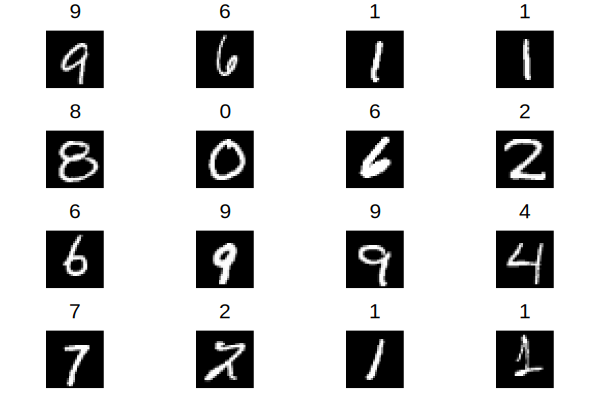

In [5]:
idx = rand(1:length(imgs), 16)
plot([plot(imgs[i], title="$(labels[i])", aspect_ratio=:equal, axis=false, ticks=false) for i in idx]...)

The images are 28 by 28 pixels. I believe they were originally black
ink on white paper, but the colors are being inverted somewhere. 

Continue processing the data

In [6]:
# Stack images into one large batch 
X = hcat(float.(reshape.(imgs, :))...) |> gpu;
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu;

One hot encoding is what the machine learning world calls creating
dummy variables from a categorical variable.

## Single Layer Classification

Now we define our neural network. To begin with we will look at single
hidden layer with a multinomial logit output layer. The function that
gives choice probabilities in a multinomial logit model is called the
**softmax** function. That is, 
$$
softmax(x_1, ..., x_k) = \left( \frac{e^{x_1}}{\sum_{j=1}^k e^{x_i}},
\frac{e^{x_2}}{\sum_{j=1}^k e^{x_i}}, ..., \frac{e^{x_k}}{\sum_{j=1}^k
e^{x_i}} \right)
$$

In [7]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) |> gpu

Chain(Dense(784, 32, relu), Dense(32, 10), softmax)

In this example, we are working on a classification problem; we are
trying to predict a discrete outcome instead of a continuous one.  The
output of the network above are probabilities that an image represents
each of the ten digits. That is, we forming conditional probability,
or the likelihood, of $y$ given $x$. In this situation, maximum
likelihood is a natural estimator. For discrete $y$ (like we have
here), the log likelihood is equal to minus the cross-entropy, so this
is what we use as our loss function.

In [8]:
loss(x, y) = crossentropy(m(x), y)

loss (generic function with 1 method)

Since cross-entropy or log likelihood are difficult to interpret, we
might want a more intuitive measure of our model's performance. For
classification **accuracy** is the portion of predictions that are
correct. 

<div class="alert alert-danger">
**Other measures of classification performance**

For this application accuracy is likely sufficient, but in
some situations (including rare outcomes or when we weight differently
type I and type II errors) accuracy is not a sufficient measure of a
classifier's performance. There are variety of other measures, such as
precision, recall, and AUC. See @qeclassify for [more
information](https://datascience.quantecon.org/applications/classification.html). 
</div>

In [9]:
accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

accuracy (generic function with 1 method)

`onecold` is the inverse of one-hot-encoding; `onecold` transforms a
matrix of dummy varibles (or probabilities) into an integer (the one
with the highest probability in the case of `m(x)`).

In [10]:
dataset = repeated((X, Y), 200) # each call to Flux.trian! will do 200
# gradient descent steps using the full X and Y to compute gradients
Xsmall=X[:,1:1000]
Ysmall=Y[:,1:1000] # accuracy is slower, so only compute on subset of data

# Test set 
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

evalcb = () -> @show(loss(X, Y), accuracy(Xsmall,Ysmall), accuracy(tX,tY)) 
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

Since `Flux.train!` might run for a long time, it allows us to pass a
"callback" function that gets evaluated every iteration. Here, this function
is just used to monitor progress. In some situations, we might also
want to use the callback function to save intermediate results to disk
in case the computation gets interrupted before completion. The
`Flux.throttle` function can be used to prevent the call-back function
from being evaluated too often. The code below makes `evalcb` get
evaluated at most once every 10 seconds.

In [11]:
rerun = false
modelfile = joinpath(docdir,"jmd","bson","mnist-slp.bson")
if rerun || !isfile(modelfile)
  evalcb()
  @time Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))
  evalcb()

  # save model
  cpum = cpu(m)
  @save modelfile cpum
else
  @load modelfile cpum
  m = gpu(cpum)
end

Chain(Dense(784, 32, relu), Dense(32, 10), softmax)

In [12]:
@show accuracy(X, Y)
@show accuracy(tX, tY);

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /home/paul/.julia/packages/GPUArrays/tIMl5/src/indexing.jl:16


accuracy(X, Y) = 0.9257166666666666
accuracy(tX, tY) = 0.9267


After 200 iterations, the accuracy is already greater than 90%. This
is pretty good. 

The test set accuracy is higher than the training set, which could
just be good luck, but it is also possible that the model is
underfitting. Let's try training the network longer (doing more
gradient descent iterations.

In [13]:
rerun = false
modelfile = joinpath(docdir,"jmd","bson","mnist-slp-2200.bson")
if rerun || !isfile(modelfile)
  evalcb()
  @time @epochs 10 Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))
  evalcb()

  # save model
  cpum = cpu(m)
  @save modelfile cpum
else
  @load modelfile cpum
  m = gpu(cpum)
end
@show accuracy(X, Y)
@show accuracy(tX,tY);

accuracy(X, Y) = 0.9909166666666667
accuracy(tX, tY) = 0.9639


Remember that each "epoch" does one gradient descent step for each
tuple in `dataset`. In the code above `dataset` is just the original
data repeated 200 times. We ran for 10 epochs, so there were a total
of 2000 more gradient descent iterations. We see that the training
accuracy has improved to above 99%, but our test accuracy has failed to
improve much above 96%. 

My initial interpretation of this result would be that we are now
overfitting. The number of parameters in the network is

In [14]:
nparam(m) = sum([length(m[i].W) + length(m[i].b) for i in 1:length(m) if typeof(m[i]) <: Dense])
nparam(m)

25450

and there 60000 images. For a typical econometric or statistic
problem, there are too many parameters for the number
of observations. One solution to this situation is to reduce the
number of parameters. Another solution is to do what lasso does and
**regularize**. Lasso regularizes by adding a penalty to the loss
function. Limiting the number of gradient descent iterations can also
act as a form of regularization. This is often called [Landweber
regularization](https://en.wikipedia.org/wiki/Landweber_iteration). It
underlies the common procedure of training a neural network until the
training loss starts to be much less than loss on a held out portion
of the data (or the loss on the held out portion stops decreasing).


## Deep Classification 

Given the apparent overfitting of the single layer network above, I
would be reluctant to move to an even more complex model. However, I
would be mistaken. If you glance through the [MNIST benchmarks on
LeCun's website](http://yann.lecun.com/exdb/mnist/), you will see that
@ciresan2010 achieve a much higher test accuracy with a 6 layer
network. Let's try their network architecture.  We will use their
numbers of layers and hidden units, but with rectified linear
activation. They used tanh activation functions.

In [15]:
cmgsnet = Chain(
  Dense(28^2, 2500 , relu),
  Dense(2500, 2000 , relu),
  Dense(2000, 1500 , relu),
  Dense(1500, 1000 , relu),
  Dense(1000, 500 , relu),
  Dense(500, 10),
  softmax) |> gpu
loss(x, y) = crossentropy(cmgsnet(x), y)
accuracy(x, y) = mean(onecold(cmgsnet(x)) .== onecold(y))
evalcb = () -> @show(loss(X, Y), accuracy(Xsmall,Ysmall), accuracy(tX,tY)) 

println("cmgsnet has $(nparam(cmgsnet)) parameters!!!")

cmgsnet has 11972510 parameters!!!


That's a deep network.

In [16]:
rerun = false
batchsize=30000 
parts=Base.Iterators.partition(1:size(X,2), batchsize) 
data = repeat([(X[:,p], Y[:,p]) for p in parts], 10);
# The full data + network doesn't fit in my GPU memory, so do 2 batches
epochs = 20
acctest  = zeros(epochs)
acctrain = zeros(epochs)
losstest  = zeros(epochs)
losstrain = zeros(epochs)
for e in 1:epochs
  modelfile = joinpath(docdir,"jmd","bson","cmgsnet-$e-epochs.bson")
  global cmgsnet 
  if rerun || !isfile(modelfile)
    println("Beginning epoch $e")
    evalcb()
    @show cmgsnet
    @time Flux.train!(loss, params(cmgsnet), data, opt, cb = throttle(evalcb, 10))
    evalcb()
    
    # save model
    cpum = cpu(cmgsnet)
    @save modelfile cpum
  else
    @load modelfile cpum
    cmgsnet = gpu(cpum)
  end
  println("Finished $e epochs")
  losstrain[e]=Tracker.data(loss(X,Y))
  acctrain[e]=accuracy(X, Y)
  losstest[e]=Tracker.data(loss(tX,tY))
  acctest[e]=accuracy(tX,tY)
end

Finished 1 epochs
Finished 2 epochs
Finished 3 epochs
Finished 4 epochs
Finished 5 epochs
Finished 6 epochs
Finished 7 epochs
Finished 8 epochs
Finished 9 epochs
Finished 10 epochs
Finished 11 epochs
Finished 12 epochs
Finished 13 epochs
Finished 14 epochs
Finished 15 epochs
Finished 16 epochs
Finished 17 epochs
Finished 18 epochs
Finished 19 epochs
Finished 20 epochs


This model achieved a testing accuracy of 98.37% after 13 training
epochs. Each training epoch consisting of 10 passes through the data
split into two batches, so 20 gradient descent iterations. Let's plot
the loss and accuracy vs epoch.

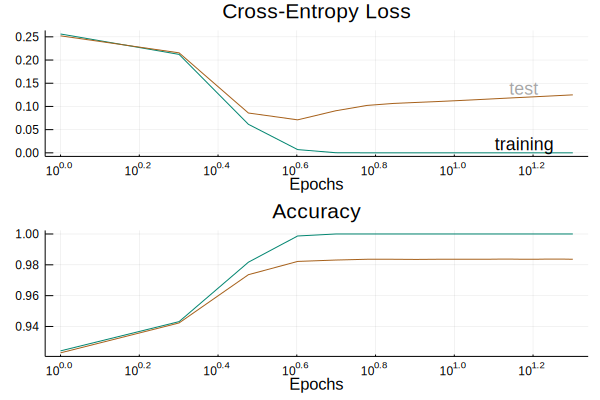

In [17]:
plot(
  plot([losstrain, losstest], xscale=:log10, xlab="Epochs", title="Cross-Entropy Loss",
       annotations=[(15, losstrain[15],
                     Plots.text("training", pointsize=12, valign=:bottom,
                                 color=get(cscheme,1))),
                    (15, losstest[15],
                     Plots.text("test", pointsize=12, valign=:bottom,
                                color=get(cscheme,0)))], leg=false,
       color_palette=get(cscheme,[1,0])
       ),
  plot([acctrain, acctest], xscale=:log10, xlab="Epochs", title="Accuracy",
       leg=false,
       color_palette=get(cscheme,[1,0])
       ),
  layout=(2,1)
)

There is really something remarkable going on in this example. A model
that appears extremely overparameterized manages to predict very well
on a test set. 

One important thing to keep in mind is that image classification
is very different from the typical estimation problems in applied
economics. In regressions and other models of economic variables, we
never expect to be able to predict perfectly. An $R^2$ of 0.4 in a
cross-sectional earnings regression is typical, or even high. Image
classification is very different. We know there is a model (our eyes)
that can classify nearly perfectly. In the language of econometrics,
the error term is zero, or there is no uncertainty, in the "true"
image classification models. 

TODO: Add an aside about adversarial examples and failures to
generalize. 
    
Let's look at some of the images that our model failed to classify
correctly.

mean(mlabels .== tlabels) = 0.9836
sum(mlabels .!= tlabels) = 164


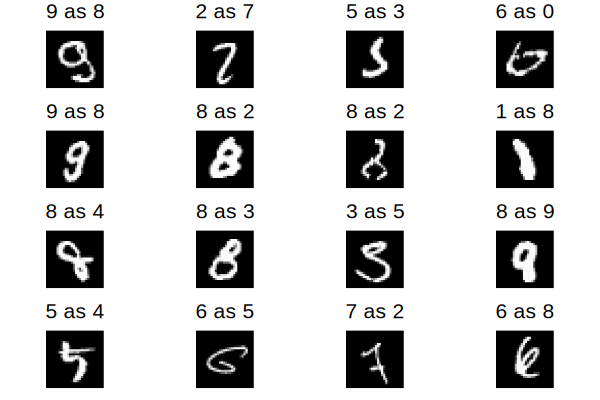

In [18]:
tlabels = MNIST.labels(:test)
timgs = MNIST.images(:test)
# predicted labels
mlabels = cpu(onecold(cmgsnet(tX))).-1
@show mean(mlabels.==tlabels) # = accuracy
@show sum(mlabels .!= tlabels)
miss=findall(mlabels .!= tlabels)
plot( [plot(timgs[i], axis=false, ticks=false, title="$(tlabels[i]) as $(mlabels[i])", aspect_ratio=:equal) for i in miss[1:16]]...)

Our model still does not have state-of-the-art accuracy. @ciresan2010
achieves 99.65% accuracy. There are differences in terms of activation
function and gradient descent details between @ciresan2010 and the
code above. However, I suspect that the main reason for their better
performance is that @ciresan2010 generate additional training
images. They do this by randomly rotating, stretching, and adding
oscillations to the existing images. 




# References